In [1]:
import pickle
from util.params import Params
from util.env import set_param
from main import Main
import torch
from models.GDN import GDN
from test_loop import test
from train_loop import train
import pandas as pd
from util.data import getAttacks
from evaluate import createMetrics

In [2]:

path = "./snapshot/gdn_swat_filtered/25_03_30_10_48_11/0/"


In [3]:
param: Params = pickle.load(file=open(f"{path}param.pickle", "rb"))
param.val_ratio=0
set_param(param)
print(param.task)

Tasks.next_label


In [4]:
main = Main(param=param)

# DATASET 

*Datasets.swat_filtered*
#####################################
sensors count:  31
actuators count:  6
consts count:  15
consts:  {'P102': 1, 'P201': 1, 'P202': 1, 'P204': 1, 'P206': 1, 'P401': 1, 'P402': 2, 'P403': 1, 'P404': 1, 'UV401': 2, 'P501': 2, 'P502': 1, 'P601': 1, 'P603': 1, 'attack': 0.0}
#####################################
['FIT101', 'LIT101', 'MV101', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'PIT501', 'PIT502', 'PIT503', 'FIT601']
Model is trained. Loading from file .....


In [5]:
print(len(main.train_dataloader),len(main.val_dataloader),len(main.test_dataloader))

7701 0 7030


In [6]:
train_avg_loss, train_result = test(main.model, main.train_dataloader)
train_avg_loss

c:\Users\moji\miniconda3\envs\cuda_12_4\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


1.4637429090927608e-16

In [7]:

# val_avg_loss, val_result = test(main.model, main.val_dataloader)
# val_avg_loss

In [8]:
test_avg_loss, test_result = test(
            main.model, main.test_dataloader
        )
test_avg_loss

11.102194828528996

In [9]:
print("max: ",test_result[0].max(),
    #   val_result[0].max(),
      train_result[0].max())
print("min: ",test_result[0].min(),
    #   val_result[0].min(),
      train_result[0].min())


max:  tensor(3.3177e-14, device='cuda:0') tensor(2.9976e-14, device='cuda:0')
min:  tensor(0., device='cuda:0') tensor(3.4973e-20, device='cuda:0')


numebr of attacks =  54621
First attack index is :  1749
Last attack index is :  445185
Number of attacks:  35
Minimum attack len:  100
Maximum attack len:  35899
Mean attack len:  1559.6


<Axes: title={'center': 'all attacks'}>

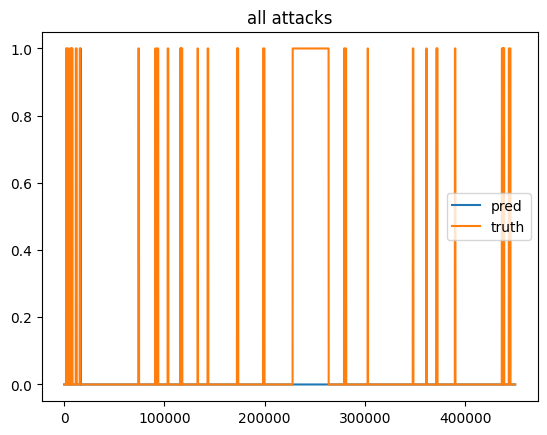

In [10]:
minimum=0#val_result[0].min()
maximum=train_result[0].max().item()*.9#*24.5

pred=torch.where((test_result[0]>maximum) ,torch.tensor(1),torch.tensor(0)).cpu().numpy()
labels_df=pd.DataFrame({"pred":pred,"truth":test_result[2].cpu().numpy()})
attacks=getAttacks(labels_df,"truth")
labels_df.plot(title="all attacks")

c:\Users\moji\miniconda3\envs\cuda_12_4\Lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


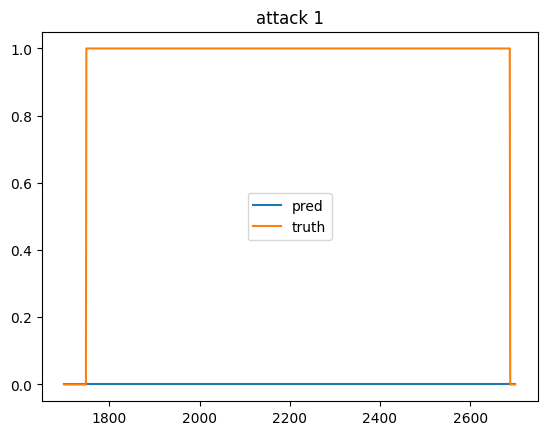

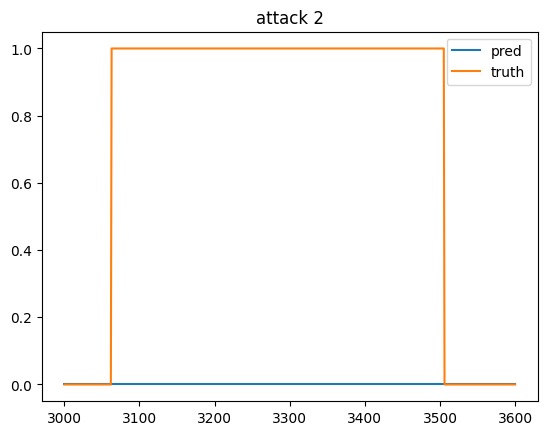

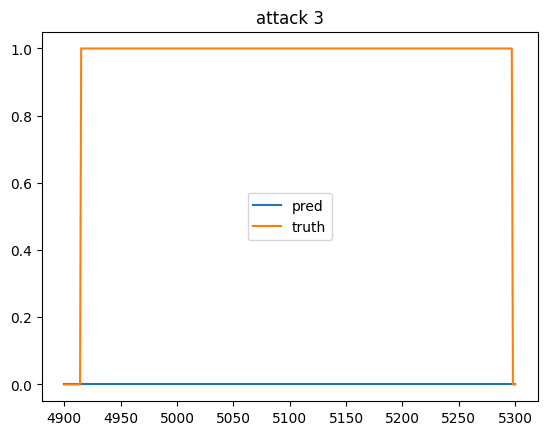

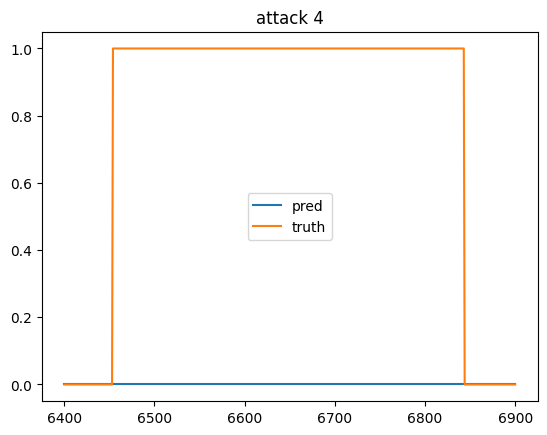

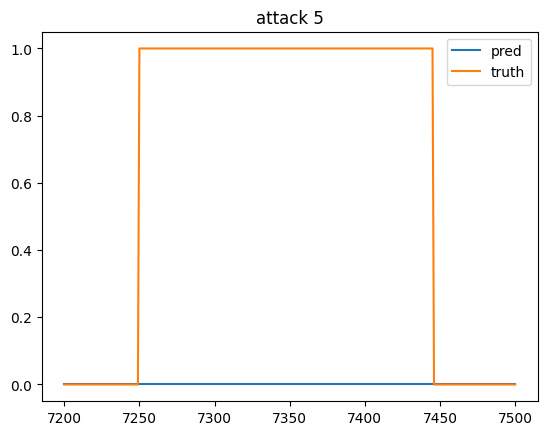

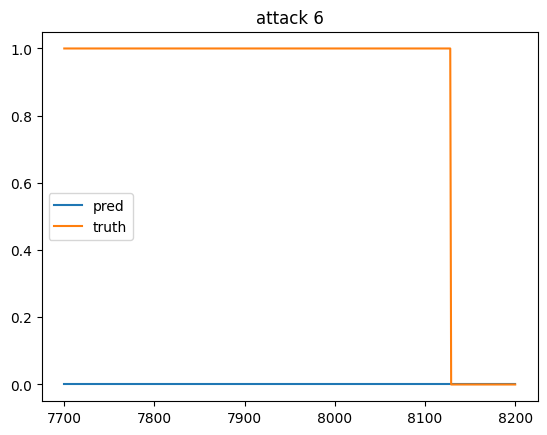

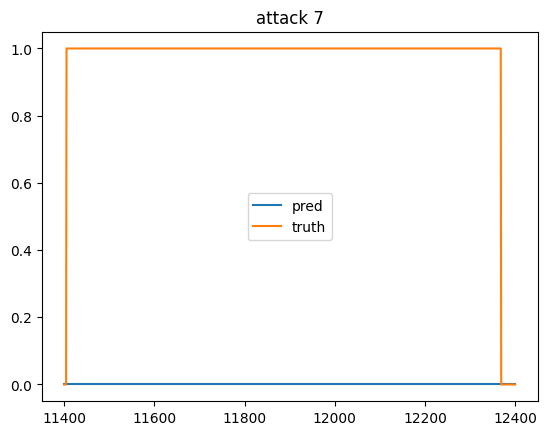

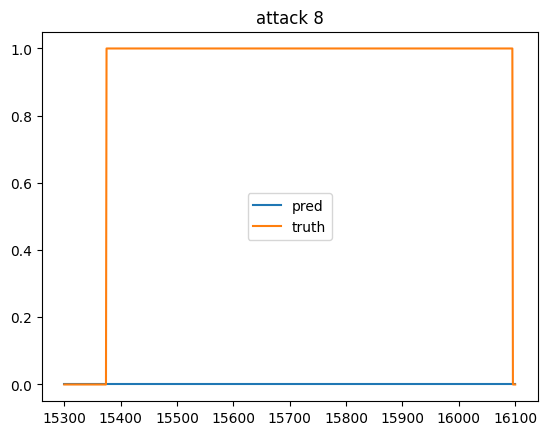

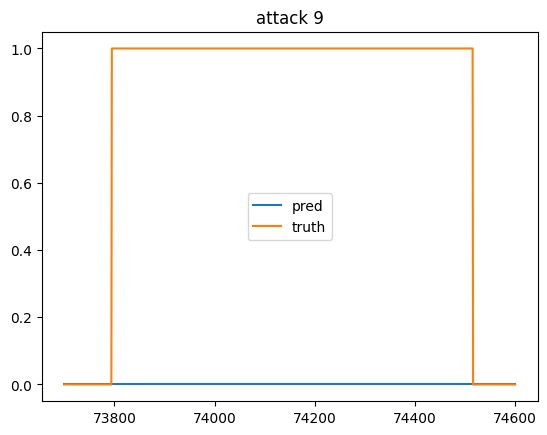

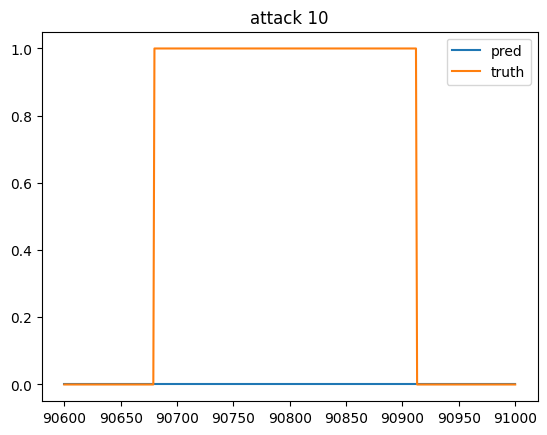

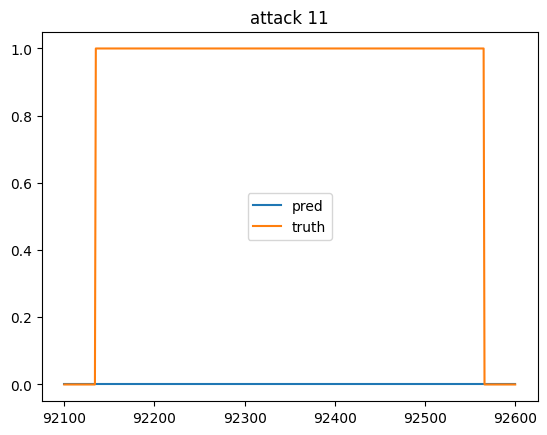

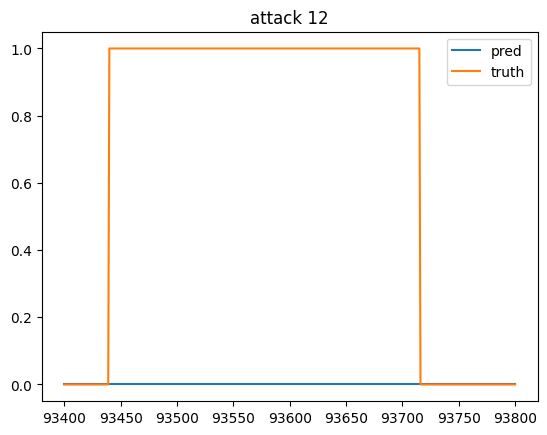

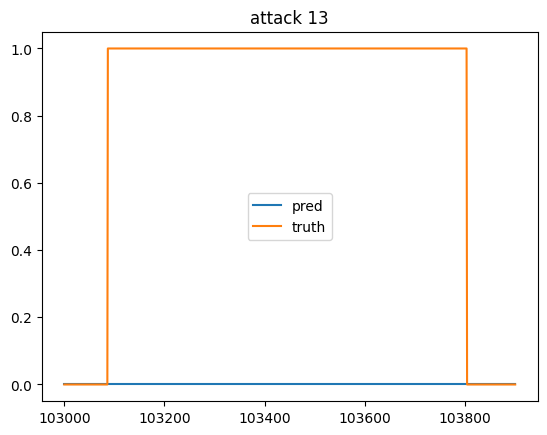

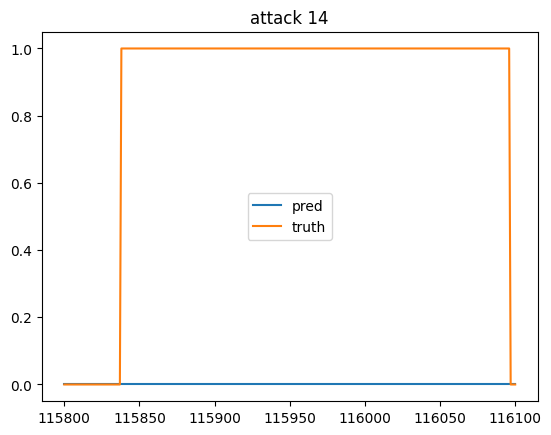

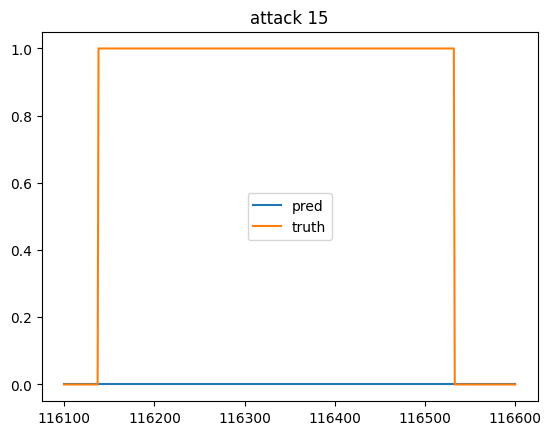

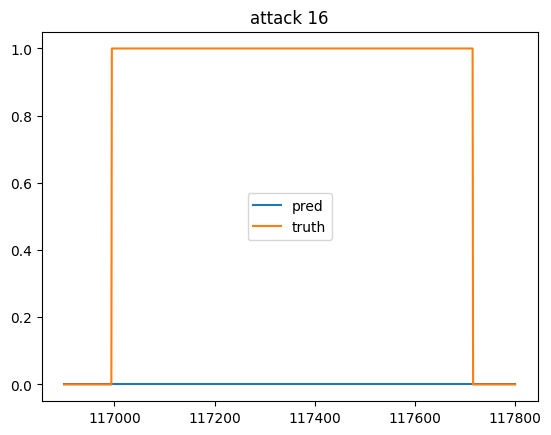

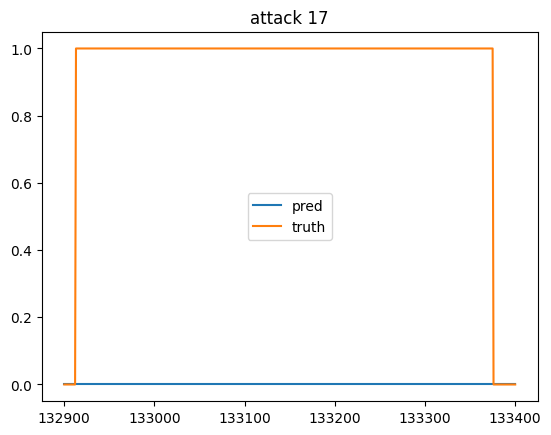

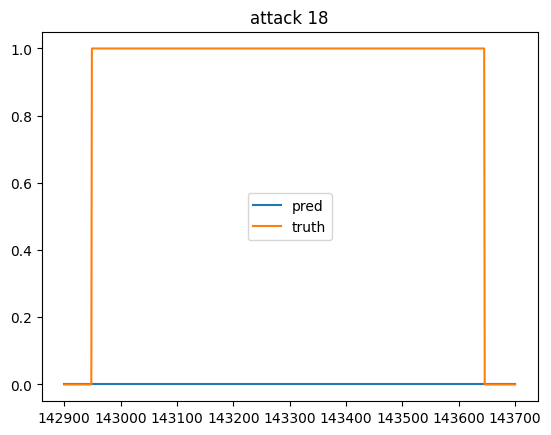

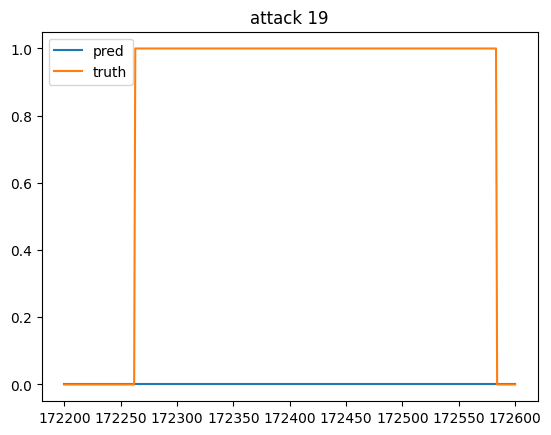

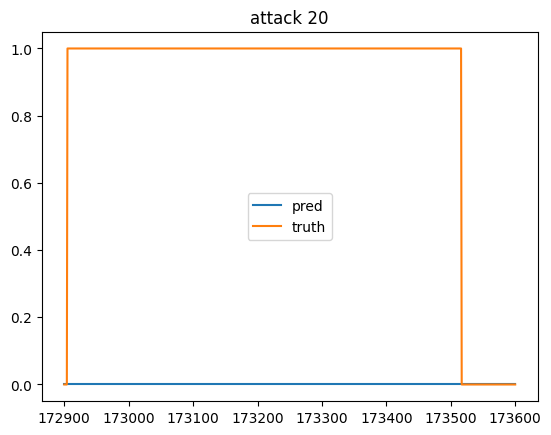

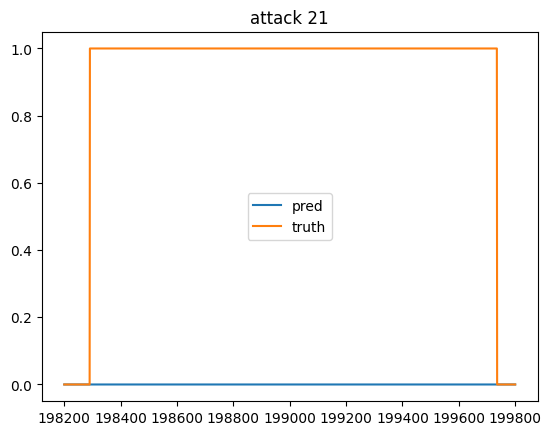

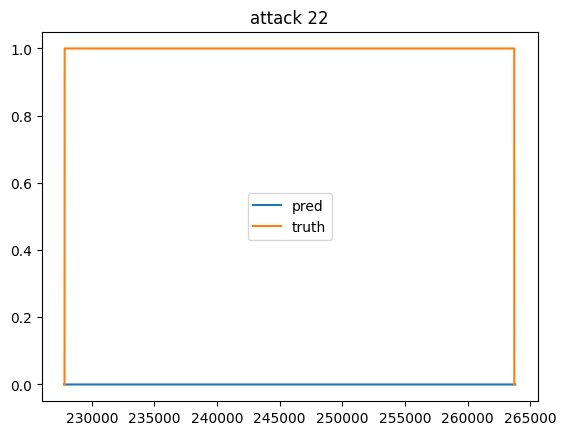

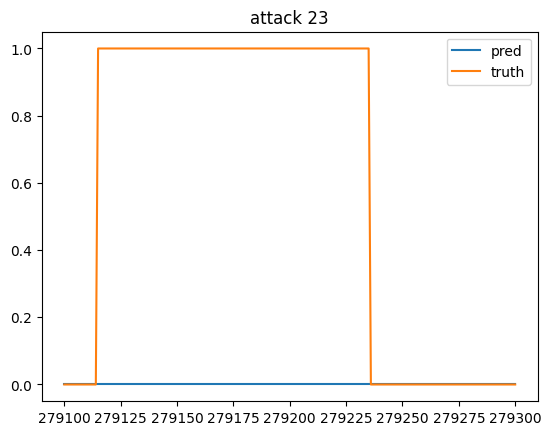

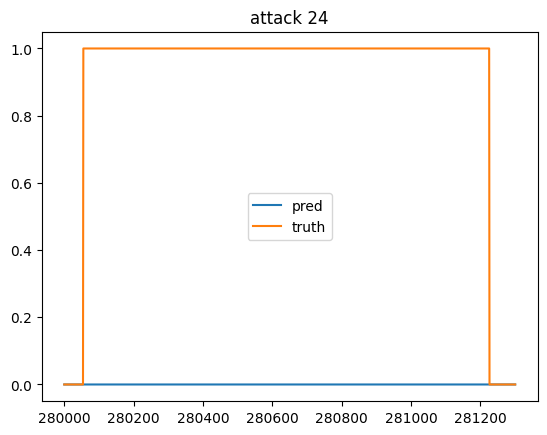

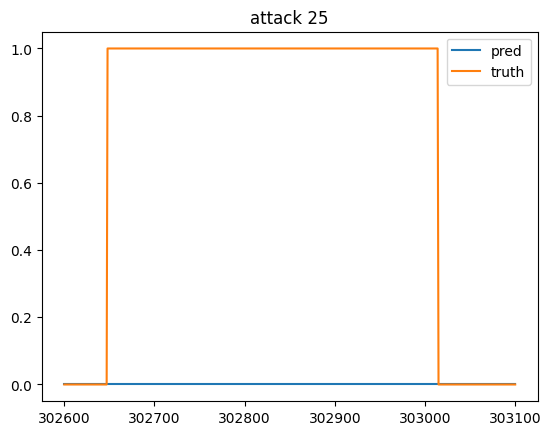

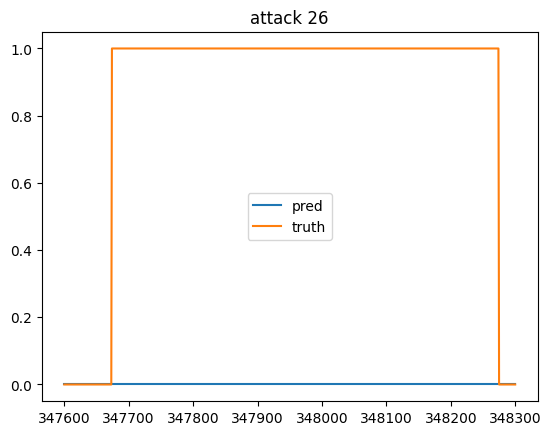

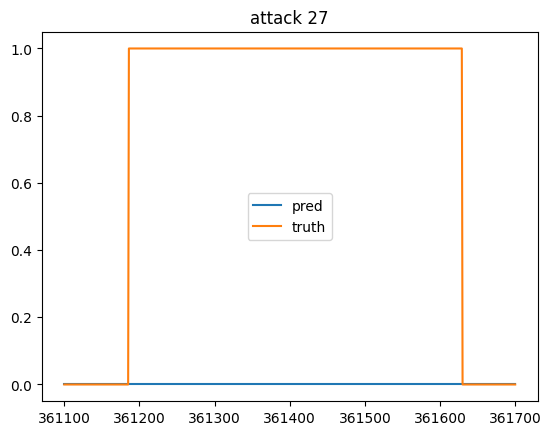

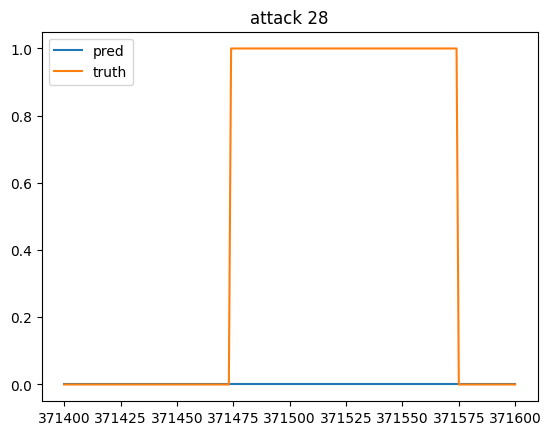

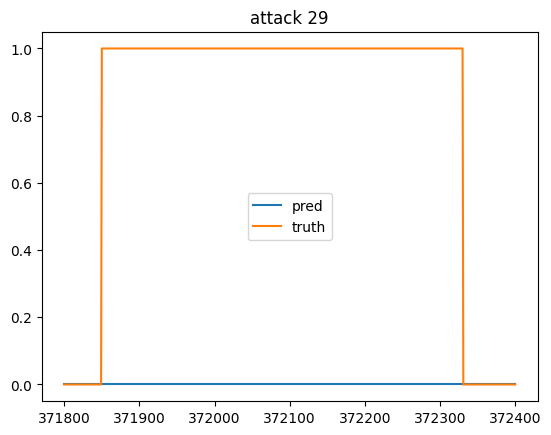

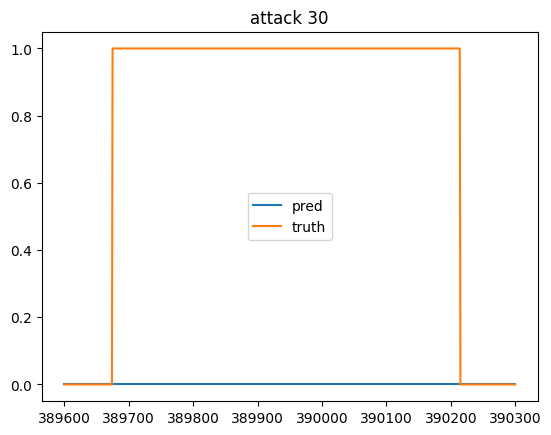

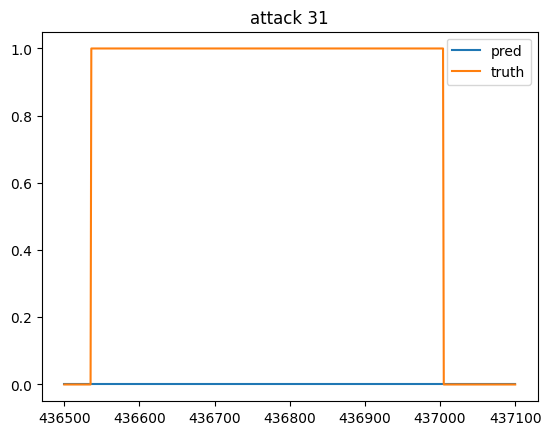

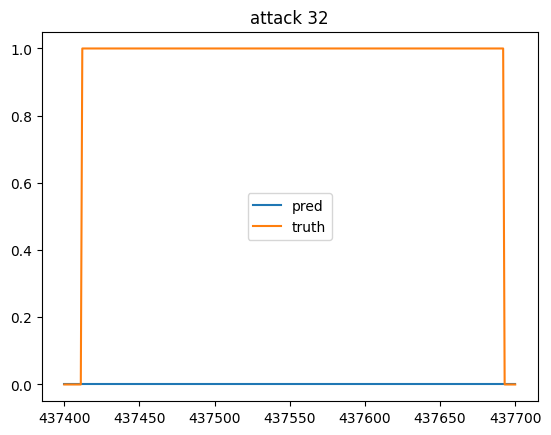

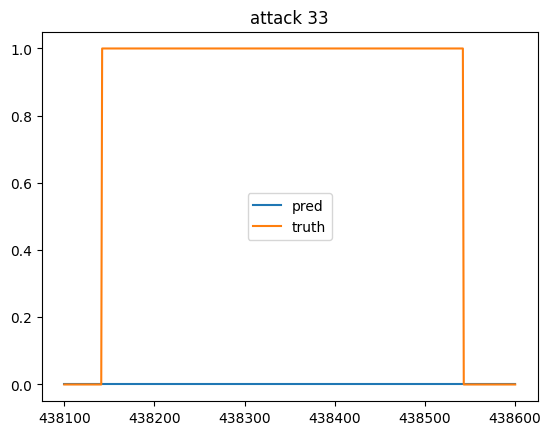

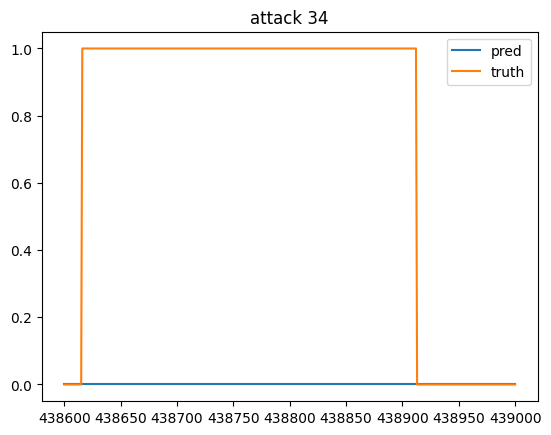

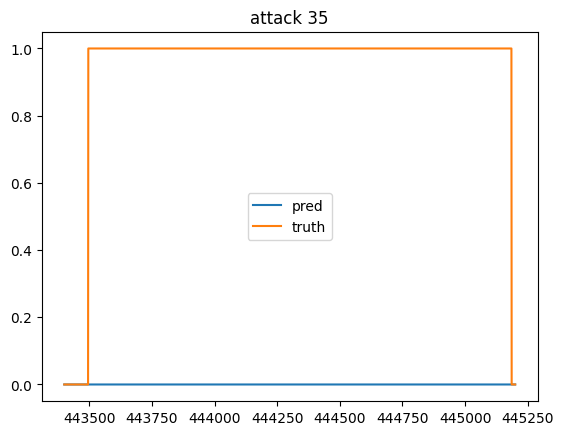

In [11]:

for i,attack in enumerate(attacks):
    left=(attack[0]//100)*100
    right=((attack[1]//100)+1)*100
    labels_df.loc[left:right].plot(title=f"attack {i+1}")

In [12]:
k=createMetrics(test_result,maximum)
print(k)
k.keys()

{'TP': 0, 'FP': 6, 'TN': 395287, 'FN': 54621, 'Accuracy': 0.7834679484367371, 'Precision': tensor(0., device='cuda:0'), 'Recall': tensor(0., device='cuda:0'), 'F1': 0.0}


dict_keys(['TP', 'FP', 'TN', 'FN', 'Accuracy', 'Precision', 'Recall', 'F1'])

In [13]:
k2=['TP', 'FP', 'TN', 'FN']
k1=["Accuracy","Precision","Recall","F1"]
d1={key:[] for key in k1}
d2={key:[] for key in k2}
x=[]
for i in range(100):
    _max=maximum*(.5+i/100)
    rr=createMetrics(test_result,_max)
    x.append(_max)
    for key  in d1.keys():
        d1[key].append(float(rr[key]))
    for key  in d2.keys():
        d2[key].append(float(rr[key]))

<Axes: >

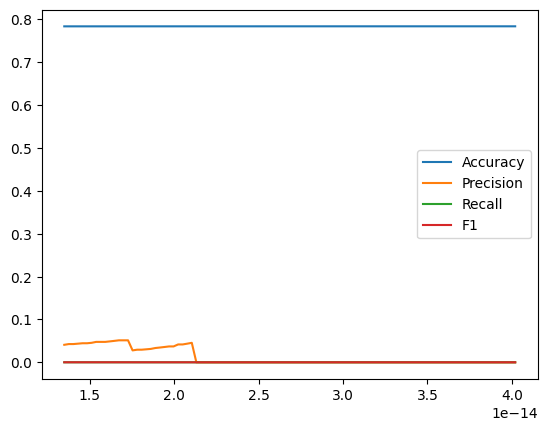

In [14]:
df1=pd.DataFrame(d1,index=x)
df1.plot()

<Axes: >

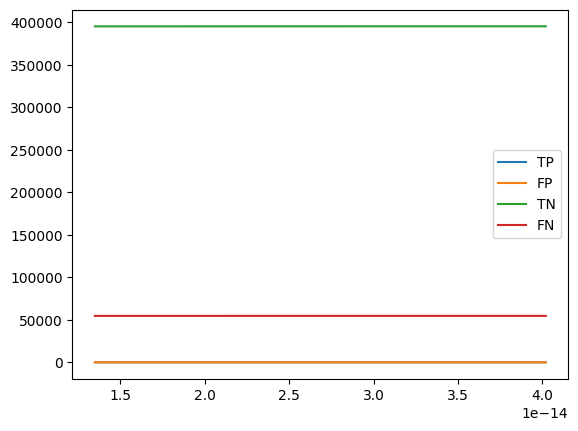

In [15]:
df2=pd.DataFrame(d2,index=x)
df2.plot()